In [11]:
import numpy as np
import zarr,os,glob 


def read_pyOM3(dir = 'raw_snap',zarr_file = 'snap.zarr',prec = np.float64,
              overwrite = True,t_start=None,t_end=None):
    
    print('reading data from directory ',dir) 
    if overwrite:
        print('defining the new zarr file ',zarr_file)
    else:
        print('assuming existing zarr file ',zarr_file)
        
    times = os.listdir(dir+'/pe=0/')
    n_pes_x, n_pes_y = np.load(dir+'/decomposition.npy')
    n_pes_x, n_pes_y = int(n_pes_x), int(n_pes_y)

    # read spatial axis and determine shapes and chunks
    xt, yt, zt = np.load(dir+'/xt.npy'), np.load(dir+'/yt.npy'), np.load(dir+'/zt.npy')
    xu, yu, zu = np.load(dir+'/xu.npy'), np.load(dir+'/yu.npy'), np.load(dir+'/zu.npy')
    nx,ny,nz, nt = xt.shape[0], yt.shape[0], zt.shape[0], len( times  )
    nx_c,ny_c,nz_c = nx//n_pes_x, ny//n_pes_y, nz

    # read time axis
    t=[]
    for d in times:  t.append( np.load(dir+'/pe=0/'+  d + '/t.npy')  )
    t = np.array(t)    
    n_sorted = np.argsort(t)
    t = np.sort(t)

    if not t_start: t_start = 0
    if not t_end  : t_end   = nt       
    #if overwrite: t_start, t_end = 0 , nt    
    if not overwrite: print('reading/writing only time slice(s) ',t_start,' to ',t_end)
    
        
    if overwrite:
       # create zarr file and store axis
       store = zarr.group(zarr_file,overwrite=True)

       t_ = store.create_array("time",shape=(nt,),chunks=(nt,) ,dtype= prec,dimension_names=("time",))
       t_.attrs.update( {"units": "seconds","long_name": "UTC time","calendar": "standard"})
       t_[:]= np.array(t)  
       xt_ = store.create_array("xt",shape=(nx,),chunks=(nx,),dtype=prec,dimension_names=("xt",))
       yt_ = store.create_array("yt",shape=(ny,),chunks=(ny,),dtype=prec,dimension_names=("yt",))
       zt_ = store.create_array("zt",shape=(nz,),chunks=(nz,),dtype=prec,dimension_names=("zt",))   
       xt_.attrs.update({"units": "m","long_name": "x coordinate T grid"})
       yt_.attrs.update({"units": "m","long_name": "y coordinate T grid"})
       zt_.attrs.update({"units": "m","long_name": "z coordinate T grid"})
       xt_[:], yt_[:], zt_[:] = xt, yt, zt

       xu_ = store.create_array("xu",shape=(nx,),chunks=(nx,),dtype=prec,dimension_names=("xu",))
       yu_ = store.create_array("yu",shape=(ny,),chunks=(ny,),dtype=prec,dimension_names=("yu",))
       zu_ = store.create_array("zu",shape=(nz,),chunks=(nz,),dtype=prec,dimension_names=("zu",))   
       xu_.attrs.update({"units": "m","long_name": "x coordinate U grid"})
       yu_.attrs.update({"units": "m","long_name": "y coordinate U grid"})
       zu_.attrs.update({"units": "m","long_name": "z coordinate U grid"})
       xu_[:], yu_[:], zu_[:] = xu, yu, zu

       u_ = store.create_array("u",shape=(nt,nz,ny,nx),chunks=(1,nz_c,ny_c,nx_c),dtype=prec,dimension_names=("time","zt","yt","xu"))
       v_ = store.create_array("v",shape=(nt,nz,ny,nx),chunks=(1,nz_c,ny_c,nx_c),dtype=prec,dimension_names=("time","zt","yu","xt"))
       w_ = store.create_array("w",shape=(nt,nz,ny,nx),chunks=(1,nz_c,ny_c,nx_c),dtype=prec,dimension_names=("time","zu","yt","xt"))
       u_.attrs.update({"units":"m/s","long_name":"zonal velocity"})
       v_.attrs.update({"units":"m/s","long_name":"meridional velocity"})
       w_.attrs.update({"units":"m/s","long_name":"vertical velocity"})

       temp_ = store.create_array("temp",shape=(nt,nz,ny,nx),chunks=(1,nz_c,ny_c,nx_c),dtype=prec,dimension_names=("time","zt","yt","xt"))
       temp_.attrs.update({"units":"deg C","long_name":"Temperature"})
       salt_ = store.create_array("salt",shape=(nt,nz,ny,nx),chunks=(1,nz_c,ny_c,nx_c),dtype=prec,dimension_names=("time","zt","yt","xt"))
       salt_.attrs.update({"units":"g/kg","long_name":"Salinity"})
       p_s_ = store.create_array("p_s",shape=(nt,ny,nx),chunks=(1,ny_c,nx_c),dtype=prec,dimension_names=("time","yt","xt"))
       p_s_.attrs.update({"units":"m^2/s^2","long_name":"Surface pressure"})
    else:
       store = zarr.open_group('snap.zarr', mode='r+')
       t_ = store['time'] 
       if t_.shape[0] < nt:
          print('directory',dir,'contains ',nt,'time steps')
          print('file ',zarr_file,'contains only ',t_.shape[0],' time steps') 
          print('resizing variables in file ',zarr_file)
          t_.append(t[t_.shape[0]:])
          for var in ('u','v','w','temp','salt','p_s'):
              store[var].resize( (nt,*store[var].shape[1:]))
              
    # store data in zarr file
    n=0
    for i in n_sorted:       
        m, d = n, times[i]
        if m>=t_start and m <t_end:
           print('reading from sub directory',times[i],' which contains time step ',m) 
           for pe in range(n_pes_x*n_pes_y):
               #print('working on PE',pe,' of ',n_pes_x*n_pes_y)
               blk_x , blk_y  = np.mod(pe,n_pes_x), np.mod(pe//n_pes_x,n_pes_y)  
               for var in ('u','v','w','temp','salt','p_s'):
                   #print(var)
                   data =  np.load(dir+'/pe=%i/'%pe + d + '/%s.npy'%var)              
                   sl = (m,slice(None),slice(blk_y*ny_c,(blk_y+1)*ny_c),slice( blk_x*nx_c,(blk_x+1)*nx_c) )
                   if len(data.shape)==2: sl= (m,slice(blk_y*ny_c,(blk_y+1)*ny_c),slice( blk_x*nx_c,(blk_x+1)*nx_c) )
                   store[var][sl] = data
        n+=1    
    print(zarr_file,' contains now ',nt,' time steps')           
    print('done')
    return

read_pyOM3(overwrite=True)

reading data from directory  raw_snap
defining the new zarr file  snap.zarr
reading from sub directory n=0  which contains time step  0
reading from sub directory n=576  which contains time step  1
reading from sub directory n=1152  which contains time step  2
reading from sub directory n=1728  which contains time step  3
reading from sub directory n=2304  which contains time step  4
reading from sub directory n=2880  which contains time step  5
reading from sub directory n=3456  which contains time step  6
reading from sub directory n=4032  which contains time step  7
reading from sub directory n=4608  which contains time step  8
reading from sub directory n=5184  which contains time step  9
reading from sub directory n=5760  which contains time step  10
reading from sub directory n=6336  which contains time step  11
reading from sub directory n=6912  which contains time step  12
reading from sub directory n=7488  which contains time step  13
reading from sub directory n=8064  which c

39.0


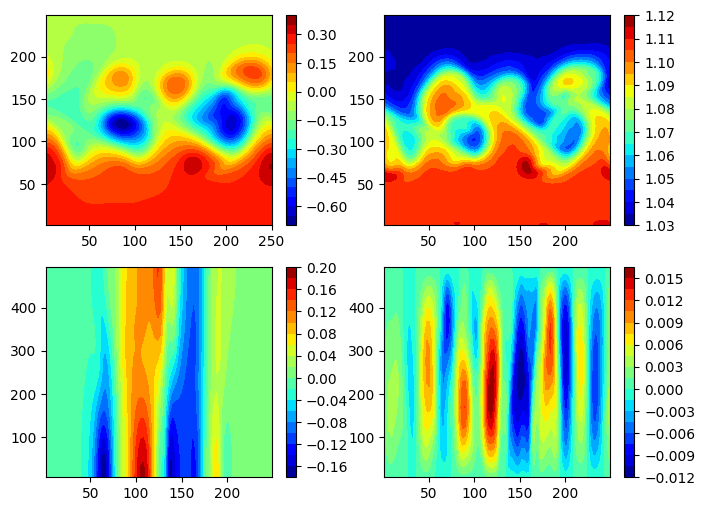

In [9]:
import pylab as plt
import zarr
snap = zarr.open_group('snap.zarr', mode='r')

n=-1
print(snap['time'][n]/86400.)
xt,xu = snap['xt'][:],snap['xu'][:]
yt = snap['yt'][:]
zt = snap['zt'][:]

u = snap['u'][n,:,:,:]
v = snap['v'][n,:,:,:]
w = snap['w'][n,:,:,:]
temp = snap['temp'][n,:,:,:]
p_s = snap['p_s'][n,:,:]

fig = plt.figure(figsize=(4*2,3*2))
ax = fig.add_subplot(2,2,1) 
co = ax.contourf(xu/1e3,yt/1e3,p_s,20,cmap='jet') 
fig.colorbar(co)
ax = fig.add_subplot(2,2,2) 
co = ax.contourf(xt/1e3,yt/1e3,temp[-5,:,:]*100,20,cmap='jet') 
fig.colorbar(co)
ax = fig.add_subplot(2,2,3) 
co = ax.contourf(yt/1e3,zt,u[:,:,0],20,cmap='jet') 
fig.colorbar(co)
ax = fig.add_subplot(2,2,4) 
co = ax.contourf(yt/1e3,zt,w[:,:,0]*100,20,cmap='jet') 
fig.colorbar(co)
plt.show()